In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt
import ngfunction

In [2]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [3]:
pars.set_matter_power(redshifts=[0.7], kmax=1.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [4]:
kh, z, pk = results.get_matter_power_spectrum(minkh=2e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [5]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [6]:
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.6210583881231838

Derivata composta della distanza cìdi luminosità

dr/dz =  c/H

dl = (1+z)*r 

dl'= r + (1+z)*c/H

In [25]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!

f = (results.get_fsigma8()/results.get_sigma8())
dl = results.luminosity_distance(z[0])
d= results.comoving_radial_distance(z[0])
 

fl= (2*d/(1+z[0]))/(d+(1+z[0])*2.99e5/H(z[0]))

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati


numpy.ndarray

In [8]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = float((bias + fl *f * mu[j]**2)**2*pk[:,i])


In [9]:
##Errori dei dati simulati
ng= ngfunction.Ng(z[0])*10**4/h**3   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= 2* np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= 2*np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol/(2*np.pi)**3 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [10]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.015750493585308428

In [11]:
#faccio una trasformata di fuorier: considero il volume del guscio sferico come il volume di un cubo

Diag = np.sqrt(3) * (64)**(1/3)
2*np.pi/Diag

0.906899682117109

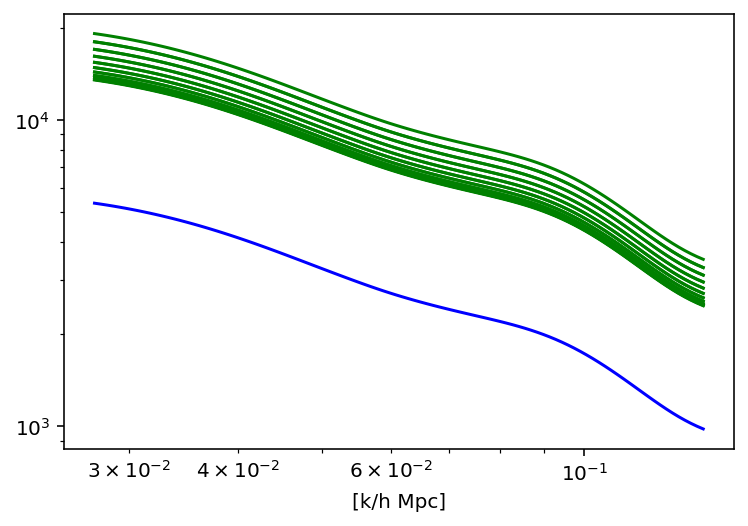

In [12]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[3305.47040162 3230.28756292 3155.60970004 3081.46938575 3007.89868561
 2934.92910808 2862.59305521 2790.92711505 2719.96755702 2649.74916013
 2580.30519053 2511.66738229 2443.86762578 2376.94346718 2310.93188722
 2245.86709529 2181.78057175 2118.70111562 2056.65663578 1995.68216146
 1935.81231632 1877.07753847 1819.50423089 1763.11492283 1707.92964325
 1653.97384247 1601.27243533 1549.84540349 1499.70805401 1450.87130462
 1403.3430765  1357.13863312 1312.2746181  1268.76210139 1226.60693325
 1185.81018722 1146.36824633 1108.2687008  1071.49269186 1036.01924083
 1001.82561153  968.88755725  937.18019995  906.69099511  877.41728876
  849.35300476  822.48860585  796.81159207  772.30405184  748.91158294
  726.55992579  705.17975182  684.70668907  665.08092225  646.24647017
  628.15066085  610.74445126  593.98221221  577.82138249  562.2183093
  547.1270674   532.50485726  518.31218701  504.50953958  491.03944152
  477.8409048   464.8588604   452.04380162  439.34975052  426.73470035
  414.1

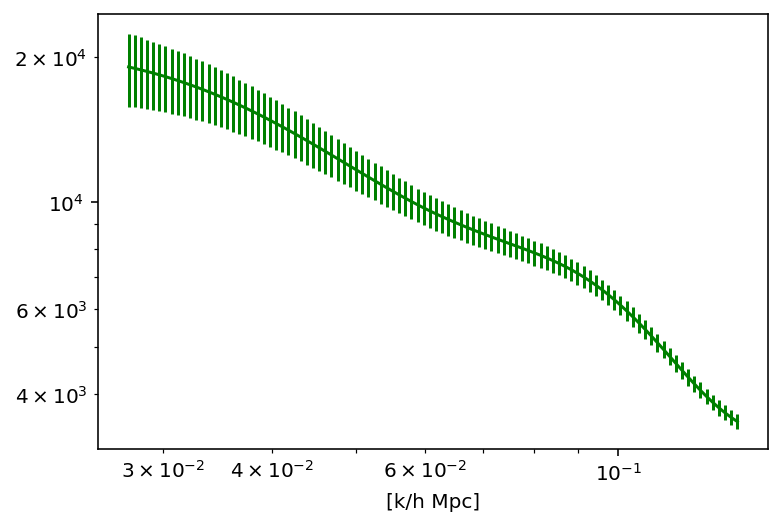

In [13]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [14]:
gammas= np.arange(0.4,0.6,0.005)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma)*fl * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



Text(0, 0.5, 'Chi^2')

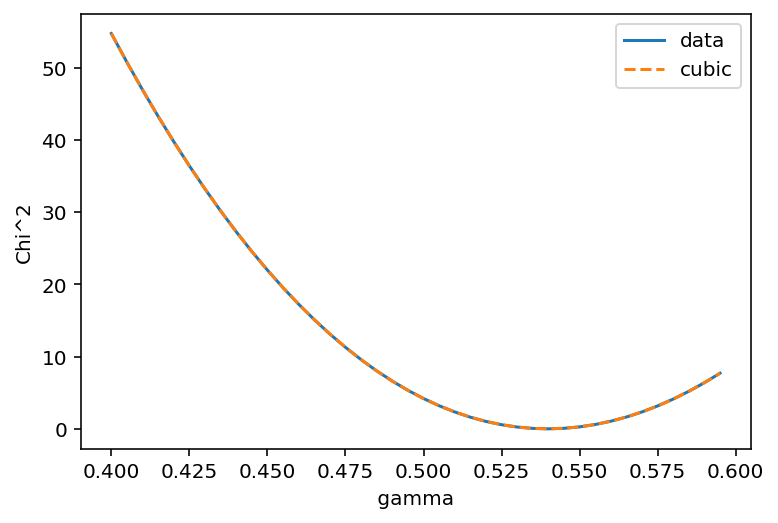

In [15]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])
plt.xlabel(' gamma ')
plt.ylabel('Chi^2')


#plt.axis([0.54,0.56,0,3])

In [16]:
type(interpol)
y=lambda x: interpol(x)


In [17]:

minimo = optimize.least_squares(y,0.5)
min1= float(minimo.x)
chi2min= y(min1)
minimo

 active_mask: array([0.])
        cost: 2.0170008491019825e-15
         fun: array([6.35137914e-08])
        grad: array([-1.63857168e-09])
         jac: array([[-0.02579868]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 14
        njev: 14
  optimality: 1.6385716822751062e-09
      status: 1
     success: True
           x: array([0.53974823])

In [18]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

0.54

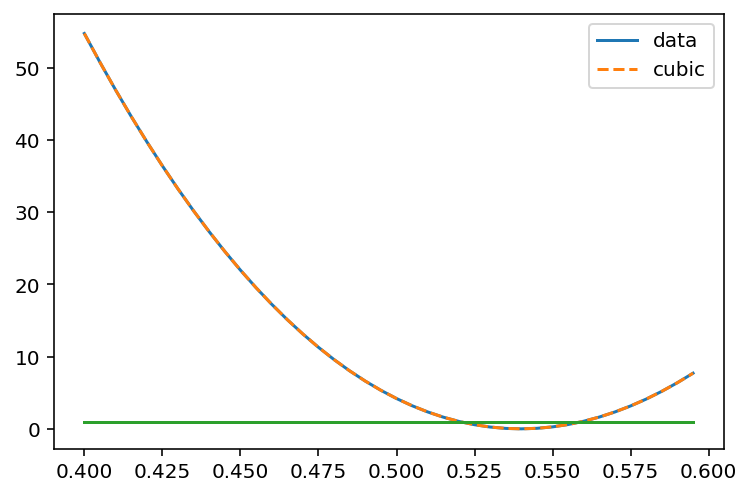

In [19]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.4,0.6,0.005)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [20]:
y2= lambda x: interpol(x) - 1 -chi2min
intersec1 = optimize.brentq(y2,0.45,min1)    #trova le soluzioni in un intervallo fissato
intersec2 = optimize.brentq(y2,min1,0.58)
print(intersec1,intersec2)

0.5202499391394373 0.5594610835741556


In [21]:
err1=(np.abs(min1-intersec1))
err2=(np.abs(min1-intersec2))

print(err1,err2)

sigma = round(err1,3)
print(sigma)

0.019498289068925034 0.019712855365793258
0.019


In [22]:
print("Il valore di gamma trovat è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovat è:  0.54  +-  0.019


In [26]:
##ULTERIORE TEST SUL CHI2
chi2_ = np.zeros(len(gammas))

for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2_[k]= chi2_[k]+(float((bias + f*fl *(mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2


In [27]:
min2_= np.min(chi2_)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min_ = np.argmin(chi2_)
gamma_min_ = gammas[index_min_]
min2_

0.0